## Buisness Problem:
  - Goat city is ordering Covid vaccines and is fully aware that not everyone will get the vaccine. Goat city wants to know how many Covid vaccines they should be ordering.
## Dataset:
Data sourced from [DataDriven](https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/)
Datadriven description of the dataset says:
> Vaccines for H1N1 were first publicly available in the United States in October 2009, when the United States government began a vaccination campaign. We will look at data from the National 2009 H1N1 Flu Survey collected to monitor vaccination rates during that campaign. This phone survey asked people whether they had received H1N1 and seasonal flu vaccines, in conjunction with information they shared about their lives, opinions, and behaviors. A better understanding of how these characteristics have been associated with personal vaccination patterns may provide guidance for future public health efforts.
>
The data has already been split into a train and test set, however, we do not have access to the testing set's labels. For now, our group will be focusing ONLY on the h1n1 vaccine label.

## Business Problem
- Stakeholder
    - Goat City Government/ Health Department
-Business problem:
    - GOAT city in random state is ordering Covid vaccines and is fully aware that not everyone will get the vaccine. 
    - GOAT city wants to know how many Covid vaccines they should be ordering.
-Target: H1N1
- Cost of different errors FP/FN
- False Positive: Model predicts they will get the vaccine, but didn't.
Ordering too many vaccines and wasting money/material
- False Negative: Model predicts they won't get the vaccine, but did.
Vaccine shortage. Loss of life.
-Metric:
    - Recall
    - F1-score

In [162]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
!pip install category_encoders

In [26]:
# Training labels
training_labels = pd.read_csv('../Data/training_set_labels.csv', index_col='respondent_id')
training_features = pd.read_csv('../Data/training_set_features.csv', index_col='respondent_id')

## Exploratory Data Analysis

In [27]:
# Training labels
features_df = pd.read_csv('../Data/training_set_features.csv')
lables_df = pd.read_csv('../Data/training_set_labels.csv')

- Lets look into the details of each dataset. 
- The features_df and training_labels will be X within our models.
- The lables_df and training_features will be y within our models.

In [28]:
# Visually confirm expected results
training_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


- We need to drop the 'seasonal_vaccine' column since our target will be 'h1n1_vaccine.' (This will be done below during data preparation.)

In [31]:
# Checking features statistics
training_features.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


- It appears that ALL of these are categorical variables/features, because there are no "true" floats.

In [32]:
# Checking Data Types
training_features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

- We are most likley going to have to OneHotEncode most of these features.

#### Checking for NaN Values

In [29]:
# Checking Features
training_features.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [30]:
# Checking labels
training_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

Were there variables you dropped or created?
How did you address missing values or outliers?
Why are these choices appropriate given the data and the business problem?
Can you pipeline your preparation steps to use them consistently in the modeling process?

- Our X will be all the variables in features_df. y will be the 'h1n1 vaccine' survey data from lables_df.

In [137]:
X = features_df
y = lables_df[['h1n1_vaccine']] #we are dropping the "seasonal_vaccine" column

In [38]:
#X.drop(columns=['respondent_id'], inplace= True)
'''should we leave respondent id in there since it has meaning to Goat City Health Dept.?'''

'should we leave respondent id in there since it has meaning to Goat City Health Dept.?'

In [138]:
y.value_counts()

h1n1_vaccine
0               21033
1                5674
dtype: int64

In [139]:
y.values

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [140]:
y.index

RangeIndex(start=0, stop=26707, step=1)

In [ ]:
sns.barplot(x=None, y=None, data=None,)

In [41]:
X['health_insurance'].value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [42]:
X['health_insurance'].isna().sum()

12274

In [43]:
X['health_insurance'].fillna(2)

0        1.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
26702    2.0
26703    1.0
26704    2.0
26705    0.0
26706    1.0
Name: health_insurance, Length: 26707, dtype: float64

In [46]:
X['employment_industry'].isna().sum()

13330

In [47]:
X['employment_occupation'].isna().sum()

13470

- Two columns cannot be just filled in with random object. Therefore, we will work on those columns using CountEncoder and SimpleImputer, which will be covered in next section.

In [44]:
X['employment_industry'].value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [45]:
X['employment_occupation'].value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

## Pipeline

The following process was obtained from following source, as cited:
- Berlin L. Lindseyberlin/Cat-in-the-dat-project. GitHub. https://github.com/lindseyberlin/Cat-in-the-Dat-Project. Published October 17, 2021.

- We will split the data into use set and hold set. Use set will be the one we will use to train and validate the model. Hold set will be our technical test set.

In [49]:
# split use and hold 
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=0)

# split train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
# initialize three columns
num_cols = []
ohe_cols = []
freq_cols = []

In [51]:
# make the lists of columns
# num = any columns with numerical value
# ohe = any columns with object value with less than 10 unique values
# freq = any columns with object value with 10 or more unique values
for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

- Let's check which columns are in each list. (sanity check)

In [52]:
num_cols

['respondent_id',
 'h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [53]:
ohe_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

In [54]:
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

We will create pipeline for each types of cols for preprocessing.

- num: scale with MinMaxScaler and apply IterativeImputer to fill the NA values.
- ohe: apply SimpleImputer to fill NA values and encode with OneHotEncoder.
- freq: encode with CountEncoder and apply SimpleImputer to fill the NA values.

In [55]:
num_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('num_imputer', IterativeImputer(max_iter = 15))
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

- Combine 3 pipelines using ColumnTransformer to create 1 preprocessor. Then, fit the preprocessor to X_train dataset.

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [57]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('num_imputer',
                                                  IterativeImputer(max_iter=15))]),
                                 ['respondent_id', 'h1n1_concern',
                                  'h1n1_knowledge', 'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  

# Modeling
Describe and justify the process for analyzing or modeling the data.

Questions to consider:

How will you analyze the data to arrive at an initial approach?
How will you iterate on your initial approach to make it better?
What model type is most appropriate, given the data and the business problem?

## Modeless Baseline

In [33]:
# Modeless Baseline
training_labels['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

- In this context, a modeless baseline would have an accuracy of ~0.79 and would guess 0 every single time.

### 1. Logistic Regression
#### 1.1 Baseline Model
Our first model will be logistic regression. We will start with no parameters

In [60]:
# Create a pipeline combining preprocessor and classifier
# classifier = LogisticRegression()
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [61]:
# Cross validate the model
cross_validate(lr_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([3.7566123 , 3.67645478, 3.91091084, 3.90071487, 3.47228599]),
 'score_time': array([0.08072186, 0.10082316, 0.10143518, 0.08632803, 0.07553506]),
 'test_score': array([0.83852095, 0.83781886, 0.83758484, 0.83407442, 0.83103206]),
 'train_score': array([0.83571261, 0.83600515, 0.83571261, 0.83764334, 0.83875497])}

- Cross validation shows that there is no overfitting.

In [62]:
# fit the model
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [ ]:
# Predict on validation set
lr_preds = lr_clf.predict(X_val)
X_val

- Based on the prediction, we will caculate the metrics: accuracy, recall, f1, and roc_auc.

In [64]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, lr_preds)))
print('recall {:0.3f}'.format(recall_score(y_val, lr_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , lr_preds)))

accuracy: 0.822
recall 0.400
f1: 0.496
roc_auc: 0.670


- Although the accuracy is high, recall and f1 is less than 0.5. AUC might be at the higher side.

- We will also generate the confusion matrix to visualize the FN/FP cases.

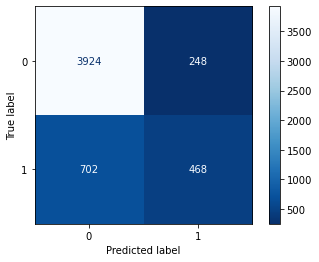

In [66]:
plot_confusion_matrix(lr_clf, X_val, y_val, cmap = "Blues_r")

### 1.2 Iteration
- Lets try the gridsearch, we will look at 3 parameters for logistic regression:
    - penalty
    - C
    - class_weight

In [68]:
params={'classifier__penalty':['l2', 'l1','elasticnet'],
        'classifier__C':[ 0.1, 1, 10, 100, 101, 102,103,104,105],
        'classifier__class_weight':['balanced', None]
       }

In [69]:
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='f1')
output = grid_clf.fit(X_train, y_train)

In [70]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_clf.best_params_, 
                                                  grid_clf.best_score_))

Best Param:{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}, Best f1:0.581


The result shows the best model, so far, is:

- C = 0.1
- class_weight = 'balanced'
- penalty = l2

### 1.3 Model 2.0
The output with best estimator will be our model 2.0. We will go through the same process with that of model 1.0.

In [72]:
output.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [73]:
cross_validate(output.best_estimator_, X_train, y_train, return_train_score=True)

{'fit_time': array([3.78498411, 3.42940688, 3.40334201, 3.37836981, 3.13035965]),
 'score_time': array([0.09012794, 0.07692194, 0.07767296, 0.07806516, 0.07285404]),
 'test_score': array([0.77486543, 0.78586473, 0.78656681, 0.77135502, 0.76363211]),
 'train_score': array([0.77831734, 0.77779078, 0.77550901, 0.77948748, 0.78176925])}

- Cross validation shows that there is no overfitting.

In [74]:
val_preds = output.best_estimator_.predict(X_val)

In [75]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, val_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, val_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, val_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , val_preds)))

accuracy: 0.773
recall: 0.712
f1: 0.578
roc_auc: 0.751


- Although the accuracy went down, there were great improvement in recall and f1 score. Lets visualize the confusion matrix.

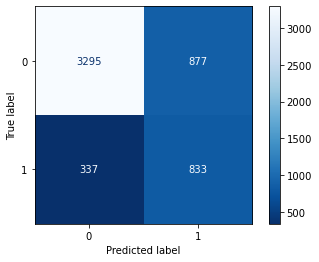

In [76]:
plot_confusion_matrix(output.best_estimator_, X_val, y_val, cmap="Blues_r")

- The confusion matrix shows that in return of the high recall, the precision score went down.

### 1.4 ROC Curve
We will create a function for the roc curve for the multiple use.

In [77]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

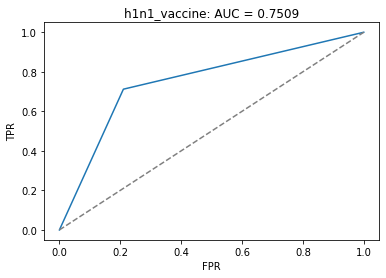

In [78]:
# Initialize the fig, ax
fig, ax = plt.subplots()

# plot roc curve
plot_roc(
    y_val, 
    val_preds, 
    'h1n1_vaccine',
    ax = ax
)

### 2. Naive Bayesian
#### 2.1 Baseline Model
Our second model will be Gaussian Naive Bayesian.

In [82]:
nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [83]:
cross_validate(nb_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([3.74475121, 3.38146091, 3.2239387 , 3.24010801, 3.03663015]),
 'score_time': array([0.11836791, 0.09136891, 0.09199786, 0.09120202, 0.08704185]),
 'test_score': array([0.76175989, 0.75520711, 0.76199392, 0.7516967 , 0.75567517]),
 'train_score': array([0.7601802 , 0.75684531, 0.75567517, 0.7593026 , 0.7584835 ])}

- Cross validation shows that there is no overfitting.

In [84]:
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [85]:
nb_preds = nb_clf.predict(X_val)

In [86]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds)))

accuracy: 0.756
recall: 0.623
f1: 0.528
roc_auc: 0.708


- Accuracy score is lower than Logistic Regression. However, recall, f1, ROC_AUC is higher than those of the baseline Logistic Regression Model.

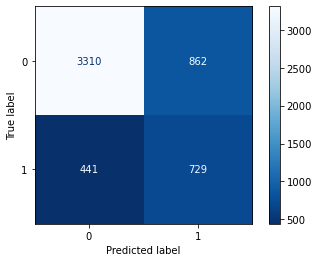

In [97]:
plot_confusion_matrix(nb_clf, X_val, y_val, cmap="Blues_r")

- Confusion Matrix shows that recall is higher than Precision.

### 2.2 Tuning
For GaussianNB, there is only one parameter to tune, which is var_smoothing.

In [98]:
params={'classifier__var_smoothing':np.logspace(0,-9, num=100),
       }

In [99]:
grid_nb = GridSearchCV(nb_clf, param_grid=params, scoring='f1')
output_nb = grid_nb.fit(X_train, y_train)

In [100]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(output_nb.best_params_, 
                                                  output_nb.best_score_))

Best Param:{'classifier__var_smoothing': 0.1873817422860384}, Best f1:0.539


- The model with best f1 score is var_smoothing = 0.18738...

### 2.2 Model 2.0
We will check the result for the model 2.0 with best parameter.

In [101]:
output_nb.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [102]:
cross_validate(output_nb.best_estimator_, X_train, y_train, return_train_score=True)

{'fit_time': array([3.73765802, 3.97478986, 3.75163198, 3.44083619, 3.38130188]),
 'score_time': array([0.12526798, 0.09145498, 0.09223795, 0.09203982, 0.08696103]),
 'test_score': array([0.79194945, 0.79452375, 0.79569389, 0.7856307 , 0.78539668]),
 'train_score': array([0.792359  , 0.78937515, 0.78955067, 0.79189094, 0.79177393])}

In [103]:
nb_preds2 = output_nb.best_estimator_.predict(X_val)

In [104]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds2)))

accuracy: 0.785
recall: 0.570
f1: 0.538
roc_auc: 0.708


- The result shows there is no significant difference in our model after tuning except the recall score went down. We will check the confusion matrix.

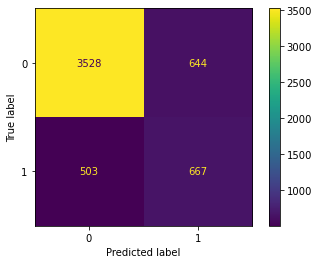

In [105]:
plot_confusion_matrix(output_nb.best_estimator_, X_val, y_val)

- We can see that precision got larger and the plot seems more balanced out than baseline model.

### 2.4 ROC Curve
Below is the ROC curve for the tuned GaussianNB

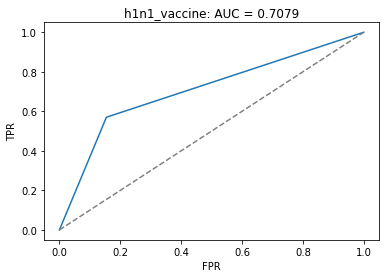

In [106]:
fig, ax = plt.subplots()
plot_roc(
    y_val, 
    nb_preds2, 
    'h1n1_vaccine',
    ax = ax
)

### 3. KNN
3.1 Baseline Model
Our third model is the K-nearest neighbors.

Our third model is the K-nearest neighbors.

In [107]:
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [108]:
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [109]:
knn_preds = knn_clf.predict(X_val)

In [110]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, knn_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, knn_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, knn_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , knn_preds)))

accuracy: 0.797
recall: 0.250
f1: 0.350
roc_auc: 0.600


- Every score seems really low else than accuracy. We will not try to tune this model since the KNN takes a lot of time to run and the model score does not seem promising.

### Random Forest
Our fourth model is Random Forest.

#### 4.1 Baseline Model

In [111]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


In [112]:
cross_validate(rf_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([5.37810779, 5.37100005, 5.85736394, 5.20403218, 5.10744715]),
 'score_time': array([0.17161822, 0.17695904, 0.16423702, 0.15688586, 0.15721703]),
 'test_score': array([0.85654107, 0.85303066, 0.85443482, 0.85069038, 0.838989  ]),
 'train_score': array([1., 1., 1., 1., 1.])}

- Cross validation score shows that the model is overfitting. The parameter tuning is needed to modify this.

In [113]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [114]:
rf_preds = rf_clf.predict(X_val)

In [115]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds)))

accuracy: 0.843
recall: 0.421
f1: 0.540
roc_auc: 0.691


- Most of the score looks high enough. We might want to try out the grid search to modify the scores since the recall is the lowest out of the models we have tried (excluding KNN).

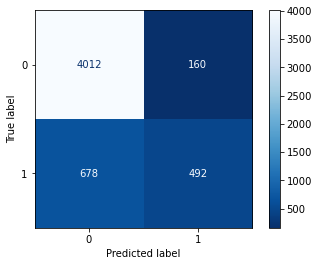

In [116]:
plot_confusion_matrix(rf_clf, X_val, y_val, cmap="Blues_r")

- As we can see the precision is really high but recall is relatively low.

#### 5.2 Tuning
Since there are too many parameters, we went through 1 parameters at a time.

'''However, we could not find specific min_samples_split since we have to go through cross validation. We will try out the min_samples_split = 20 first and check if the model is still overfitting.'''

In [167]:
rf_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 20))
])

In [148]:
rf_clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [149]:
cross_validate(rf_clf2, X_train, y_train, return_train_score=True)

{'fit_time': array([40.74587607, 38.06052685, 36.21089292, 35.33361793, 34.19977021]),
 'score_time': array([0.32852602, 0.30945706, 0.27910399, 0.27607608, 0.26413798]),
 'test_score': array([0.8525626 , 0.85349871, 0.85373274, 0.85186052, 0.84366955]),
 'train_score': array([0.92382401, 0.92552071, 0.92165926, 0.92493564, 0.92598877])}

- The train score shows that our model is still overfitting. Lets try 100.

In [150]:
rf_clf3= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 100))
])

In [151]:
cross_validate(rf_clf3, X_train, y_train, return_train_score=True)

{'fit_time': array([30.25071788, 30.80625796, 30.34145284, 30.65534329, 29.48395801]),
 'score_time': array([0.24167395, 0.24808979, 0.26499295, 0.24406576, 0.30177307]),
 'test_score': array([0.84952024, 0.85209455, 0.85349871, 0.85115844, 0.84226539]),
 'train_score': array([0.86543412, 0.86555114, 0.86666277, 0.86754037, 0.86672127])}

- Our test and train score is close so min_samples_split = 100 successfully reduced the overfit.

In [152]:
rf_clf3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [153]:
rf_preds3 = rf_clf3.predict(X_val)

In [154]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds3)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds3)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds3)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds3)))

accuracy: 0.843
recall: 0.445
f1: 0.554
roc_auc: 0.700


- Every score improved slightly. However, the recall is still low compared to other models.

### 6. Stack
Since the Random Forest shows the low recall, Logistic Regression shows the low precision, and GaussianNB is balanced, we wondered if the stacking can create a model with best of all kind.

#### 6.1 Stack 1.0
We stacked all 3 models we previously mentioned, with the tuned parameters to see how the results end up.

In [155]:
stack_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators = 300, 
                                                                                criterion = 'entropy', 
                                                                                max_features = None, 
                                                                                min_samples_split = 100, 
                                                                                max_depth = None)),
                                                 ('nb',GaussianNB(var_smoothing= 0.1873817422860384))],
                                     final_estimator = LogisticRegression(C= 10, 
                                                                          class_weight= 'balanced', 
                                                                          penalty = 'l2')))
])

In [156]:
cross_validate(stack_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([132.02032113, 131.60721993, 133.54618716, 128.6828022 ,
        128.16408205]),
 'score_time': array([0.28286505, 0.24550819, 0.25085306, 0.24276376, 0.24575901]),
 'test_score': array([0.81254388, 0.81628832, 0.82354318, 0.80950152, 0.80060847]),
 'train_score': array([0.83998362, 0.83887199, 0.83623918, 0.83577112, 0.8381114 ])}

In [157]:
stack_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [158]:
stack_preds = stack_clf.predict(X_val)

In [159]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, stack_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, stack_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, stack_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , stack_preds)))

accuracy: 0.808
recall: 0.706
f1: 0.618
roc_auc: 0.772


- The result shows that stacked model created a best results for every scores; every score reached the near highest score. However, lets also try out the model with only Random Forest and Logistic Regression since those two are inverse in recall and precision scores.

##### Stack 2.0
Stack 2.0 will stack Random Forest and Logistic Regression.

In [168]:
cross_validate(stack_clf2, X_train, y_train, return_train_score=True)

NameError: name 'stack_clf2' is not defined

In [ ]:
stack_clf2.fit(X_train, y_train)

In [ ]:
stack_preds2 = stack_clf2.predict(X_val)

In [ ]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, stack_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, stack_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, stack_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , stack_preds2)))

- The result shows slightly worse score for all. Therefore, stacking all 3 models will be a better model.

### Decison Trees

In [169]:
clf_decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [170]:
cross_validate(clf_decision_tree, X_train, y_train, return_train_score=True)

{'fit_time': array([4.5238359 , 4.8910532 , 4.48897195, 4.53568316, 3.88644075]),
 'score_time': array([0.09260821, 0.101825  , 0.10009408, 0.12173891, 0.0890193 ]),
 'test_score': array([0.75941961, 0.7872689 , 0.78586473, 0.77088696, 0.7610578 ]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [171]:
clf_decision_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['respondent_id',
                                                   'h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                  

In [176]:
decision_tree_preds = clf_decision_tree.predict(X_val)

In [177]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, decision_tree_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, decision_tree_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, decision_tree_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , decision_tree_preds)))

accuracy: 0.778
recall: 0.480
f1: 0.486
roc_auc: 0.671


In [178]:
param_decision_tree = {
    "classifier__max_depth": [1, 5, 10],
    "classifier__min_samples_split": [2, 10, 100]
}

In [180]:
grid_decision_tree = GridSearchCV(clf_decision_tree, param_decision_tree, scoring='f1')

In [181]:
output_decision_tree = grid_decision_tree.fit(X_train, y_train)

In [ ]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(output_decision_tree.best_params_, 
                                               output_decision_tree.best_score_))

In [ ]:
output_decision_tree.best_params_

In [ ]:
output_decision_tree.best_estimator_.fit(X_train, y_train)

decision_tree_gridcv_preds = output_decision_tree.best_estimator_.predict(X_val)

In [ ]:
plot_confusion_matrix(output.best_estimator_, X_val, y_val, cmap="Blues_r")

Evaluation
The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem.

Questions to consider:

How do you interpret the results?
How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
How well does your model/data fit any relevant modeling assumptions?
For the final model, you might also consider:

How confident are you that your results would generalize beyond the data you have?
How confident are you that this model would benefit the business if put into use?
What does this final model tell you about the relationship between your inputs and outputs?